In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import glob, os, re, pycountry, subprocess

H37Rv_coords_to_gene = pd.read_csv("./references/ref_genome/H37Rv_coords_to_gene.csv")
H37Rv_coords_to_gene_dict = dict(zip(H37Rv_coords_to_gene['pos'], H37Rv_coords_to_gene['region']))

H37Rv_genes = pd.read_csv("./references/ref_genome/mycobrowser_h37rv_genes_v4.csv")
H37Rv_full = pd.read_csv("./references/ref_genome/mycobrowser_h37rv_v4.csv")

epitopes_table = pd.read_csv("./references/epitopes_table.csv")

In [2]:
print(epitopes_table.locus_id.nunique())

epitopes_table = epitopes_table.merge(H37Rv_genes[['H37rv_GeneID', 'Symbol']].rename(columns={'H37rv_GeneID': 'locus_id', 'Symbol': 'Gene'}), how='left')
print(sum(pd.isnull(epitopes_table['Gene'])))

# these have a backslash in them because they span 2 genes, so fill with the Rv names
epitopes_table['Gene'] = epitopes_table['Gene'].fillna(epitopes_table['locus_id'])

df_PE_PPE = epitopes_table.query("Gene.str.contains('|'.join(['PE', 'PPE']), case=True)")
print(f"{df_PE_PPE.Gene.nunique()} PE/PPE genes have epitopes")

446
6
55 PE/PPE genes have epitopes


Filter to search for all long-read sequences

("Mycobacterium tuberculosis"[orgn:__txid1773] OR "Mycobacterium tuberculosis complex"[orgn:__txid77643]) AND ("Oxford Nanopore" OR "PacBio SMRT")

```bash
conda create -n snakemake -c conda-forge -c bioconda snakemake=7.32.4 python=3.10.14 snakemake-interface-common=1.17.3

conda config --set channel_priority strict
```

```
# check that the word "CCS" (upper or lower case) is found in the header of the FASTQ reads.
```

In [66]:
os.listdir("./FASTQ/SAMN38195838/variant_calling")

['SAMN38195838.SV.tsv',
 'SAMN38195838.variants.tsv',
 'SAMN38195838.full.vcf.gz',
 'SAMN38195838.variants.vcf',
 'SAMN38195838.SV.vcf']

In [76]:
df_variants = pd.read_csv(f"./FASTQ/SAMN38195838/variant_calling/SAMN38195838.variants.tsv", sep='\t')
df_SV = pd.read_csv(f"./FASTQ/SAMN38195838/variant_calling/SAMN38195838.SV.tsv", sep='\t')

df_variants['REGION'] = df_variants['POS'].map(H37Rv_coords_to_gene_dict)
df_SV['REGION'] = df_SV['POS'].map(H37Rv_coords_to_gene_dict)

In [ ]:
snakemake --snakefile snakefile --use-conda --conda-frontend conda --rerun-incomplete --keep-going --configfile config.yaml --conda-prefix /Users/skulkarni/Desktop/Research/LR_data/.snakemake/conda --cores 8 --unlock

snakemake --snakefile snakefile --use-conda --conda-frontend conda --rerun-incomplete --keep-going --configfile config.yaml --conda-prefix /Users/skulkarni/Desktop/Research/LR_data/.snakemake/conda --cores 8

In [3]:
pacbio_samples = pd.read_csv("pacbio_samples.tsv", header=None, sep='\t')

In [7]:
pacbio_samples.iloc[[-1], :].to_csv("pacbio_samples.tsv", header=None, sep='\t', index=False)

In [ ]:
fastplong -i {input.fastq} -o {output.fastq_trimmed} -h {output.fastplong_html} -j {output.fastplong_json} --length_required {params.min_read_length} --thread 8

# Gathering Long-Read Sequencing

In [3]:
LR_sequencing = pd.read_csv("LR_sequencing_SRA.csv").query("LibraryStrategy=='WGS' & Platform != 'ILLUMINA' & LibrarySource == 'GENOMIC'")
print(len(LR_sequencing), LR_sequencing.BioSample.nunique())

# there are some samples that were sequenced with both Oxford Nanopore and PacBio, so preferentially keep the PacBio one because it is more accurate
samples_with_nanopore_and_pacbio = LR_sequencing.groupby('BioSample')[['Platform']].nunique().query("Platform > 1").index.values

keep_pacbio_runs = LR_sequencing.query("BioSample in @samples_with_nanopore_and_pacbio").sort_values(['BioSample', 'Platform'], ascending=[True, False]).drop_duplicates('BioSample', keep='first')

LR_sequencing = pd.concat([LR_sequencing.query("BioSample not in @samples_with_nanopore_and_pacbio"), keep_pacbio_runs])

# sample SAMN40453083 has WGS with both simplex and duplex basecalling.
# duplex basecalling is more accurate because the complement (just created by PCR) strand is read immediately after the template strand,
# and the base calls for both strands are harmonized into a consensus, boosting accuracy.
keep_duplex_samples = LR_sequencing.query("BioSample=='SAMN40453083'").query("LibraryName.str.contains('duplex')")
LR_sequencing = pd.concat([LR_sequencing.query("BioSample!='SAMN40453083'"), keep_duplex_samples])

# there are some sequencing duplicates -- different Run ids or even BioSamples, but same RunHash, so drop those duplicates
LR_sequencing = LR_sequencing.drop_duplicates(subset='RunHash', keep='first')

# some H37Rv sequences deposited
LR_sequencing = LR_sequencing.loc[~((~pd.isnull(LR_sequencing['SampleName'])) & (LR_sequencing['SampleName'].str.contains('H37Rv')))]
LR_sequencing = LR_sequencing.loc[~((~pd.isnull(LR_sequencing['LibraryName'])) & (LR_sequencing['LibraryName'].str.contains('H37Rv')))]

# for this sample, there are 2 submitted reads. One has the CCS suffix, the other does not. So keep the CCS reads, which have been collapsed and processed from the raw reads 
# (the other file) to the CCS reads. The raw file is much bigger. BioSample = SAMN38195838, raw SRR ID = SRR26783283
# Couldn't find the CSS suffix in the downloaded data, but saw it in the SRA GUI
LR_sequencing = LR_sequencing.query("Run != 'SRR26783283'").reset_index(drop=True)

# remove PacBio RS sequencing because it's an older, more error-prone version?

# the other 2 ONT cases with multiple runs seem fine. Merge BAMs for the multiple sequencing runs
print(len(LR_sequencing), LR_sequencing.BioSample.nunique())

1322 1308
1287 1285


In [4]:
LR_sequencing.iloc[LR_sequencing.index.values[LR_sequencing.duplicated(subset='BioSample', keep=False)]][['BioSample', 'Run', 'CenterName', 'Platform']]

,BioSample,Run,CenterName,Platform
840,SAMEA104027311,ERR2724039,STATENS SERUM INSTITUT,OXFORD_NANOPORE
841,SAMEA104027311,ERR2724040,STATENS SERUM INSTITUT,OXFORD_NANOPORE
1285,SAMN40453083,SRR28370672,THE UNIVERSITY OF MELBOURNE,OXFORD_NANOPORE
1286,SAMN40453083,SRR28370678,THE UNIVERSITY OF MELBOURNE,OXFORD_NANOPORE


In [5]:
LR_sequencing.groupby(["BioSample", "Platform"])[['Run']].nunique().query("Run > 1")

,,Run
BioSample,Platform,
SAMEA104027311,OXFORD_NANOPORE,2
SAMN40453083,OXFORD_NANOPORE,2


In [20]:
# all_data = []

# for i, sample in enumerate(LR_sequencing.query("Platform=='OXFORD_NANOPORE'")['BioSample'].unique()):

#     try:
#         res = subprocess.Popen(f"esearch -db sra -query {sample} | efetch -format runinfo", shell=True, encoding='utf8', stdout=subprocess.PIPE)
        
#         res = res.communicate()[0]
    
#         with open("./esearch_results.temp", 'w+') as file:
#             file.write(res)
    
#         res_df = pd.read_csv("./esearch_results.temp")
#         res_df['Query'] = sample
#     except:
#         all_data.append(pd.DataFrame({"Query": sample}, index=[i]))
        
#     all_data.append(res_df)

#     if i % 100 == 0:
#         print(i)

# all_data = pd.concat(all_data)

In [6]:
bioproject_metadata_search = pd.read_csv("bioproject_metadata_search.csv")
ONT_metadata = pd.read_csv("ONT_metadata.csv")

In [7]:
matched_ONT_Illumina_sequencing = ONT_metadata.query("Platform=='ILLUMINA' & LibrarySource == 'GENOMIC' & LibraryStrategy=='WGS'").reset_index(drop=True)

ONT_metadata.Query.nunique(), matched_ONT_Illumina_sequencing.BioSample.nunique(), len(matched_ONT_Illumina_sequencing)

(1165, 297, 298)

In [8]:
matched_ONT_Illumina_sequencing.iloc[matched_ONT_Illumina_sequencing.index.values[matched_ONT_Illumina_sequencing.duplicated('BioSample', keep=False)]][['BioSample', 'Run', 'LibraryName', 'LibraryStrategy', 'LibrarySelection', 'LibrarySource',
       'LibraryLayout']]

,BioSample,Run,LibraryName,LibraryStrategy,LibrarySelection,LibrarySource,LibraryLayout
155,SAMEA104027311,ERR1949967,unspecified,WGS,RANDOM,GENOMIC,PAIRED
156,SAMEA104027311,ERR2724042,171219_PP1,WGS,RANDOM,GENOMIC,PAIRED


In [9]:
search_bioprojects = ONT_metadata.query("BioSample not in @matched_ONT_Illumina_sequencing.BioSample").BioProject.unique()
len(search_bioprojects)

19

In [10]:
not_found_biosamples = ONT_metadata.query("BioSample not in @matched_ONT_Illumina_sequencing.BioSample").BioSample.values
len(not_found_biosamples)

915

In [11]:
from difflib import get_close_matches

def find_close_matches(df1, df2, column_name, cutoff=0.6):
    """
    Finds close matches between two columns (with the same name) in two DataFrames.
    
    Args:
        df1 (pd.DataFrame): First DataFrame.
        df2 (pd.DataFrame): Second DataFrame.
        column_name (str): Name of the column to match in both DataFrames.
        cutoff (float): Minimum similarity ratio (0 to 1) to consider as a match. Default is 0.6.
        
    Returns:
        pd.DataFrame: A DataFrame containing rows from both DataFrames and their closest matches.
    """
    matches = []

    for value in df1[column_name].dropna().unique():
        close_match = get_close_matches(value, df2[column_name].dropna().unique(), n=1, cutoff=cutoff)
        if close_match:
            matches.append({
                f'{column_name}_df1': value,
                f'{column_name}_df2': close_match[0]
            })

    return pd.DataFrame(matches)

In [12]:
df_LibraryName_matches = []

for bioproject in search_bioprojects:

    result = find_close_matches(LR_sequencing.query("BioSample not in @matched_ONT_Illumina_sequencing.BioSample & Platform == 'OXFORD_NANOPORE' & BioProject == @bioproject"), 
                                bioproject_metadata_search.query("BioProject==@bioproject & Platform=='ILLUMINA' & BioProject == @bioproject"), 
                                'LibraryName', 
                                cutoff=0.8
                               )

    if len(result) > 0:
        df_LibraryName_matches.append(result)

len(df_LibraryName_matches)

5

In [13]:
df_LibraryName_matches_keep = []

for i, df_single_group in enumerate(df_LibraryName_matches):

    if i != 1:
        df_LibraryName_matches_keep.append(df_single_group.query("LibraryName_df1 == LibraryName_df2"))
    else:
        df_LibraryName_matches_keep.append(df_single_group)

df_LibraryName_matches_keep = pd.concat(df_LibraryName_matches_keep)
df_LibraryName_matches_keep.columns = ['Sample1', 'Sample2']

In [14]:
df_SampleName_matches = []

for bioproject in search_bioprojects:

    result = find_close_matches(LR_sequencing.query("BioSample not in @matched_ONT_Illumina_sequencing.BioSample & Platform == 'OXFORD_NANOPORE' & BioProject == @bioproject"), 
                                bioproject_metadata_search.query("BioProject==@bioproject & Platform=='ILLUMINA' & BioProject == @bioproject"), 
                                'SampleName', 
                                cutoff=0.8
                               )

    if len(result) > 0:
        df_SampleName_matches.append(result)

len(df_SampleName_matches)

7

In [15]:
df_SampleName_matches_keep = []

for i, df_single_group in enumerate(df_SampleName_matches):

    if i not in [0, 4]:
        df_SampleName_matches_keep.append(df_single_group.query("SampleName_df1 == SampleName_df2"))
    else:
        df_SampleName_matches_keep.append(df_single_group)

df_SampleName_matches_keep = pd.concat(df_SampleName_matches_keep)
df_SampleName_matches_keep.columns = ['Sample1', 'Sample2']

In [16]:
df_keep_mapping = pd.concat([df_LibraryName_matches_keep, df_SampleName_matches_keep]).drop_duplicates()

df_keep_mapping.columns = ['ONT', 'ILLUMINA']

df_keep_mapping.query("ONT != ILLUMINA")

,ONT,ILLUMINA
0,ELE1N,ELE1I
1,ELE2N,ELE2I
2,HUM1N,HUM1I
0,MT20823_1,MT20823


In [72]:
new_matches_ILLUMINA = bioproject_metadata_search.merge(df_keep_mapping, left_on='LibraryName', right_on='ILLUMINA').query("Platform == 'ILLUMINA'")[['BioSample', 'LibraryName', 'CenterName']].drop_duplicates()
len(new_matches_ILLUMINA)

new_matches_ONT = LR_sequencing.merge(df_keep_mapping, left_on='LibraryName', right_on='ONT')[['BioSample', 'LibraryName', 'CenterName']].drop_duplicates()
len(new_matches_ONT)

353

In [77]:
new_matches_final = new_matches_ILLUMINA.rename(columns={'BioSample': 'ILLUMINA_BioSample'}).merge(new_matches_ONT.rename(columns={'BioSample': 'ONT_BioSample'}), on=['LibraryName', 'CenterName'])
len(new_matches_final)

350

In [100]:
diff_matches_ONT = new_matches_ONT.query("LibraryName not in @new_matches_ILLUMINA.LibraryName")
diff_matches_ONT['LibraryName'] = diff_matches_ONT['LibraryName'].str.replace('N', '')

diff_matches_ILLUMINA = new_matches_ILLUMINA.query("LibraryName not in @new_matches_ONT.LibraryName")
diff_matches_ILLUMINA['LibraryName'] = diff_matches_ILLUMINA['LibraryName'].str.replace('I', '')

diff_matches_final = diff_matches_ILLUMINA.rename(columns={'BioSample': 'ILLUMINA_BioSample'}).merge(diff_matches_ONT.rename(columns={'BioSample': 'ONT_BioSample'}), on=['LibraryName', 'CenterName'])

new_matches_final = pd.concat([new_matches_final, diff_matches_final])

/var/folders/mm/bx_h3x157735lh27_3pyt4km0000gn/T/ipykernel_1383/444793396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_matches_ONT['LibraryName'] = diff_matches_ONT['LibraryName'].str.replace('N', '')
/var/folders/mm/bx_h3x157735lh27_3pyt4km0000gn/T/ipykernel_1383/444793396.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_matches_ILLUMINA['LibraryName'] = diff_matches_ILLUMINA['LibraryName'].str.replace('I', '')


In [141]:
LR_sequencing['CenterName'] = LR_sequencing['CenterName'].replace('WADSWORTH CENTER - NYS DOH', 'WADSWORTH CENTER')
matched_ONT_Illumina_sequencing['CenterName'] = matched_ONT_Illumina_sequencing['CenterName'].replace('WADSWORTH CENTER - NYS DOH', 'WADSWORTH CENTER')

matched_ONT_Illumina_sequencing_intermediate = matched_ONT_Illumina_sequencing[['BioSample', 'Run', 'LibraryName', 'CenterName']].rename(columns={'Run': 'ILLUMINA_Run'}).merge(LR_sequencing.query("BioSample in @matched_ONT_Illumina_sequencing.BioSample")[['BioSample', 'CenterName', 'Run']].rename(columns={'Run': 'ONT_Run'}), on=['BioSample', 'CenterName'])
len(matched_ONT_Illumina_sequencing_intermediate), matched_ONT_Illumina_sequencing_intermediate.BioSample.nunique()





(301, 297)

In [142]:
matched_ONT_Illumina_sequencing.query("BioSample not in @matched_ONT_Illumina_sequencing_intermediate.BioSample")[['BioSample', 'LibraryName', 'CenterName']].drop_duplicates()

,BioSample,LibraryName,CenterName


In [144]:
matched_ONT_Illumina_sequencing_intermediate.iloc[matched_ONT_Illumina_sequencing_intermediate.index.values[matched_ONT_Illumina_sequencing_intermediate.duplicated(subset='BioSample', keep=False)]]



,BioSample,ILLUMINA_Run,LibraryName,CenterName,ONT_Run
155,SAMEA104027311,ERR1949967,unspecified,STATENS SERUM INSTITUT,ERR2724039
156,SAMEA104027311,ERR1949967,unspecified,STATENS SERUM INSTITUT,ERR2724040
157,SAMEA104027311,ERR2724042,171219_PP1,STATENS SERUM INSTITUT,ERR2724039
158,SAMEA104027311,ERR2724042,171219_PP1,STATENS SERUM INSTITUT,ERR2724040
299,SAMN40453083,SRR28370698,AMtb_1__202402-illumina,THE UNIVERSITY OF MELBOURNE,SRR28370672
300,SAMN40453083,SRR28370698,AMtb_1__202402-illumina,THE UNIVERSITY OF MELBOURNE,SRR28370678


In [152]:
matched_ONT_Illumina_sequencing_final = pd.concat([new_matches_final, matched_ONT_Illumina_sequencing_intermediate])
del matched_ONT_Illumina_sequencing_final['LibraryName']
len(matched_ONT_Illumina_sequencing_final)

654

In [153]:
matched_ONT_Illumina_sequencing_final.to_csv("matched_ONT_Illumina_samples.csv", index=False)

In [97]:
df_samples_to_run.query("Platform=='PACBIO_SMRT'")[['BioSample', 'Run']].to_csv("pacbio_samples.tsv", index=False, sep='\t', header=None)
df_samples_to_run.query("Platform=='OXFORD_NANOPORE'")[['BioSample', 'Run']].to_csv("ont_samples.tsv", index=False, sep='\t', header=None)

In [44]:
df_samples_to_run.query("BioSample=='SAMN38195838'")[['BioSample', 'Run']].to_csv("pacbio_samples.tsv", index=False, sep='\t', header=None)

In [52]:
df_depth = pd.read_csv("/Users/skulkarni/Desktop/Research/LR_data/FASTQ/SAMN38195838/bam/SAMN38195838.depth.tsv.gz", compression='gzip', sep='\t', header=None)

print(len(df_depth.loc[df_depth[2] >= 10]) / len(df_depth))
print(len(df_depth.loc[df_depth[2] >= 20]) / len(df_depth))

0.9742570154767097
0.973686465382094


In [54]:
df_depth[2].median()

181.0

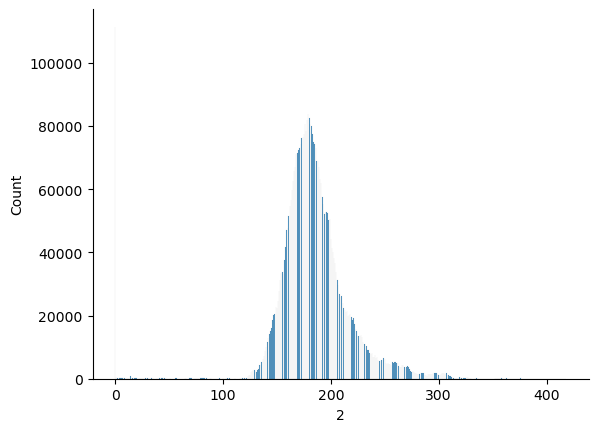

In [57]:
sns.histplot(data=df_depth,
             x=2
            )

sns.despine()
plt.show()

In [31]:
os.path.isfile("/Users/skulkarni/Desktop/Research/LR_data/FASTQ/SAMN38195838/SRR2678328/SRR26783284.blocklist")

False

In [32]:
os.path.isfile("/Users/skulkarni/Desktop/Research/LR_data/FASTQ/SAMN38195838/SRR26783284/SRR26783284.blocklist")

True

In [38]:
LR_sequencing.query("Platform=='OXFORD_NANOPORE'")[['BioSample', 'Run', 'Model']].Model.unique()

array(['MinION', 'GridION', 'PromethION'], dtype=object)

In [40]:
LR_sequencing.query("Platform=='OXFORD_NANOPORE'")[['BioSample', 'Run', 'Model']].query("BioSample=='SAMEA112850771'")

,BioSample,Run,Model
858,SAMEA112850771,ERR11275425,MinION


In [ ]:
# all will trim barcodes. primers will only trim primers and adapters, not barcodes
dorado trim ERR11275425.fastq.gz -k minion --emit-fastq

In [49]:
df_samples_to_run.query("BioSample=='SAMN38195838'")

,BioSample,Platform,Run
1214,SAMN38195838,PACBIO_SMRT,SRR26783284


In [60]:
LR_sequencing.query("Platform=='PACBIO_SMRT'").Model.value_counts()

Model
Sequel II       106
PacBio RS II     14
Sequel            9
Name: count, dtype: int64

In [105]:
LR_sequencing.query("BioSample=='SAMN38195838'")[['Platform', 'Model']]

,Platform,Model
755,PACBIO_SMRT,Sequel II


In [ ]:
Sequel II System and PacBio Revio